In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


Parameters of the largest circle:
 Center: (110, 258), Radius: 15, Sigma value: 2.0


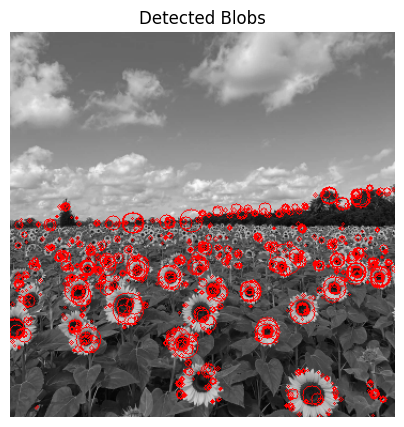

Number of detected circles: 1172
Range of σ values used: 1 to 2


In [ ]:
img = cv.imread('he_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


sigma_min = 1
sigma_max = 2
sigma_steps = 5
blob_threshold = 0.35

detected_circles = []

for current_sigma in np.linspace(sigma_min, sigma_max, sigma_steps):

    gaussian_blur = cv.GaussianBlur(gray_img, (0, 0), current_sigma)
    log_result = cv.Laplacian(gaussian_blur, cv.CV_64F)
    abs_log = np.abs(log_result)

    blob_binary = abs_log > blob_threshold * abs_log.max()
    blob_contours, _ = cv.findContours(blob_binary.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


    for blob in blob_contours:
        if len(blob) >= 5:
            (cx, cy), r = cv.minEnclosingCircle(blob)
            circle_center = (int(cx), int(cy))
            circle_radius = int(r)
            detected_circles.append((circle_center, circle_radius, current_sigma))

detected_circles.sort(key=lambda x: -x[1])

biggest_circle = detected_circles[0]
biggest_center, biggest_radius, biggest_sigma = biggest_circle
print("Parameters of the largest circle:\n", f"Center: {biggest_center}, Radius: {biggest_radius}, Sigma value: {biggest_sigma}")
circle_thickness = 1

# Draw all detected circles
result_img = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
for circle_info in detected_circles:
    c, r, _ = circle_info
    cv.circle(result_img, c, r, (0, 0, 255), circle_thickness)

plt.figure(figsize=(5, 5)), plt.imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB), cmap='gray'), plt.axis('off'), plt.title('Detected Blobs')
plt.show()

print(f"Number of detected circles: {len(detected_circles)}")

 Noisy Point Set Generation

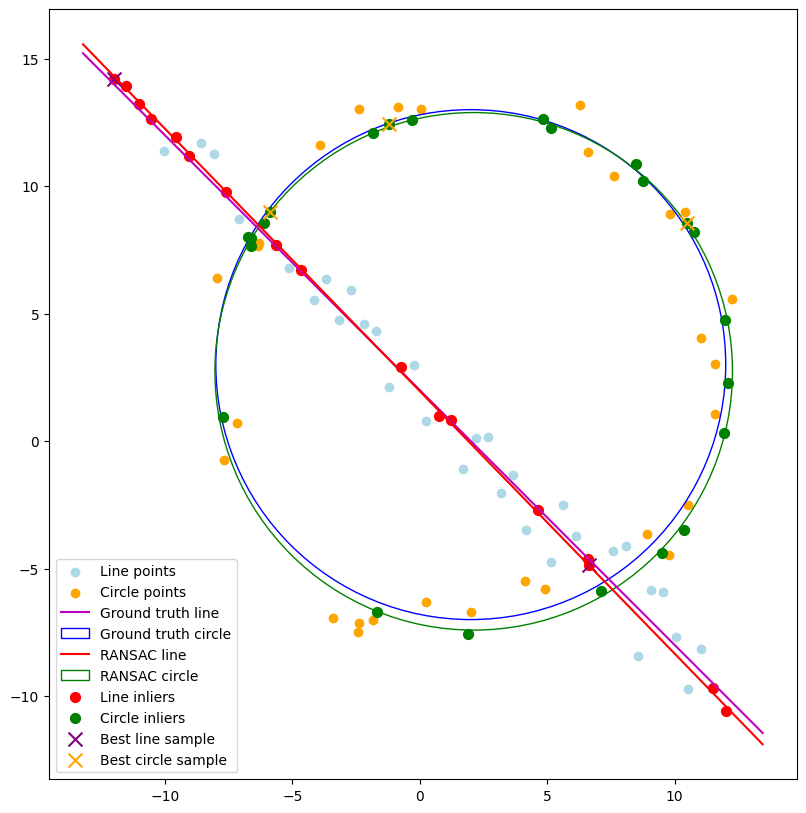

In [4]:
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(1)

# Generate noisy data points
def generate_data(N=100):
    half_n = N // 2
    r, x0_gt, y0_gt = 10, 2, 3
    s = r / 16

    # Circle points
    theta = np.random.uniform(0, 2 * np.pi, half_n)
    noise = s * np.random.randn(half_n)
    x_circle = x0_gt + (r + noise) * np.cos(theta)
    y_circle = y0_gt + (r + noise) * np.sin(theta)
    X_circle = np.column_stack((x_circle, y_circle))

    # Line points
    m, b = -1, 2
    x_line = np.linspace(-12, 12, half_n)
    y_line = m * x_line + b + np.random.randn(half_n)
    X_line = np.column_stack((x_line, y_line))

    return np.vstack((X_circle, X_line)), X_circle, X_line, (x0_gt, y0_gt, r), (m, b)

# Line equation from two points
def line_eq_from_points(p1, p2):
    dx, dy = p2 - p1
    mag = np.sqrt(dx**2 + dy**2)
    a, b = dy / mag, -dx / mag
    d = a * p1[0] + b * p1[1]
    return a, b, d

# RANSAC for line fitting
def ransac_line(X, iterations=10000, threshold=0.15, min_inliers=15):
    best_model, best_inliers = None, []

    for _ in range(iterations):
        sample = X[np.random.choice(len(X), 2, replace=False)]
        a, b, d = line_eq_from_points(sample[0], sample[1])

        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        inliers = np.where(distances < threshold)[0]

        if len(inliers) >= min_inliers and len(inliers) > len(best_inliers):
            best_model, best_inliers = (a, b, d), inliers

    return best_model, best_inliers

# Circle equation from three points
def circle_eq_from_points(p1, p2, p3):
    temp = p2[0]**2 + p2[1]**2
    bc = (p1[0]**2 + p1[1]**2 - temp) / 2
    cd = (temp - p3[0]**2 - p3[1]**2) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return cx, cy, radius

# RANSAC for circle fitting
def ransac_circle(X, iterations=10000, threshold=0.2, min_inliers=15):
    best_model, best_inliers = None, []

    for _ in range(iterations):
        sample = X[np.random.choice(len(X), 3, replace=False)]
        model = circle_eq_from_points(sample[0], sample[1], sample[2])

        if model is None:
            continue

        cx, cy, r = model
        distances = np.abs(np.sqrt((X[:,0] - cx)**2 + (X[:,1] - cy)**2) - r)
        inliers = np.where(distances < threshold)[0]

        if len(inliers) >= min_inliers and len(inliers) > len(best_inliers):
            best_model, best_inliers = model, inliers

    return best_model, best_inliers

# Optimize circle fit
def optimize_circle(initial_circle, points):
    def error(params):
        cx, cy, r = params
        return np.sum((np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)**2)

    result = minimize(error, initial_circle, method='nelder-mead')
    return result.x


# Generate data
X, X_circle, X_line, circle_gt, line_gt = generate_data()

# Fit line using RANSAC
line_model, line_inliers = ransac_line(X)

# Remove line inliers and fit circle
remaining_points = np.delete(X, line_inliers, axis=0)
circle_model, circle_inliers = ransac_circle(remaining_points)

# Optimize circle fit
optimized_circle = optimize_circle(circle_model, remaining_points[circle_inliers])

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all points
ax.scatter(X_line[:,0], X_line[:,1], color='lightblue', label='Line points')
ax.scatter(X_circle[:,0], X_circle[:,1], color='orange', label='Circle points')

# Plot ground truth
x_range = np.array(ax.get_xlim())
y_range = line_gt[0] * x_range + line_gt[1]
ax.plot(x_range, y_range, color='m', label='Ground truth line')
circle_gt_plot = plt.Circle(circle_gt[:2], circle_gt[2], color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt_plot)

# Plot RANSAC results
y_ransac = (-line_model[0] * x_range + line_model[2]) / line_model[1]
ax.plot(x_range, y_ransac, color='red', label='RANSAC line')
circle_ransac = plt.Circle(optimized_circle[:2], optimized_circle[2], color='green', fill=False, label='RANSAC circle')
ax.add_artist(circle_ransac)

# Plot inliers
ax.scatter(X[line_inliers,0], X[line_inliers,1], color='red', s=50, label='Line inliers')
ax.scatter(remaining_points[circle_inliers,0], remaining_points[circle_inliers,1], color='green', s=50, label='Circle inliers')

# Plot best samples
ax.scatter(X[line_inliers[:2],0], X[line_inliers[:2],1], color='purple', s=100, marker='x', label='Best line sample')
ax.scatter(remaining_points[circle_inliers[:3],0], remaining_points[circle_inliers[:3],1], color='orange', s=100, marker='x', label='Best circle sample')

ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()




Point 1 recorded at (109, 90)
Point 2 recorded at (406, 268)
Point 3 recorded at (393, 543)
Point 4 recorded at (72, 529)


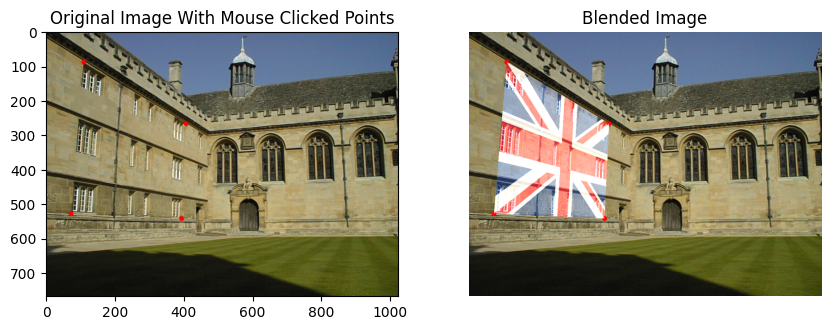

In [ ]:
MAX_POINTS = 4  # Maximum number of points to be clicked
clicked_points = np.zeros((MAX_POINTS, 2), dtype=np.float32)  # Array to store clicked points
point_count = 0

# Load the reference and overlay images
def load_images(reference_path, overlay_path):
    reference_image = cv.imread(reference_path, cv.IMREAD_COLOR)
    overlay_image = cv.imread(overlay_path, cv.IMREAD_COLOR)

    if reference_image is None or overlay_image is None:
        raise ValueError("Error loading images. Check file paths.")

    return reference_image, overlay_image

# Mouse callback function to record points clicked on the reference image
def record_mouse_clicks(event, x, y, flags, param):
    global point_count, clicked_points
    if event == cv.EVENT_LBUTTONDOWN and point_count < MAX_POINTS:
        # Draw red circle on click (optional, can be removed if not needed)
        cv.circle(reference_image, (x, y), 7, (0, 0, 255), -1)  # Draw red circle on click
        clicked_points[point_count] = [x, y]
        point_count += 1
        print(f"Point {point_count} recorded at ({x}, {y})")

# Display the reference image and capture mouse clicks
def display_image_and_capture_points(image):
    global point_count
    cv.namedWindow('Reference Image')
    cv.setMouseCallback('Reference Image', record_mouse_clicks)

    while True:
        cv.imshow('Reference Image', image)
        if point_count == MAX_POINTS:  # Exit loop when maximum points are clicked
            break
        if cv.waitKey(20) & 0xFF == 27:  # Press 'Esc' to exit
            print("Process terminated by user.")
            cv.destroyAllWindows()
            exit()

    cv.destroyAllWindows()  # Close window after selecting points

# Warp the overlay image based on selected points
def warp_overlay_image(overlay_image, target_points):
    overlay_corners = np.array([[0, 0], [overlay_image.shape[1], 0],
                                 [overlay_image.shape[1], overlay_image.shape[0]],
                                 [0, overlay_image.shape[0]]], dtype=np.float32)

    homography_matrix, _ = cv.findHomography(overlay_corners, target_points)
    warped_overlay = cv.warpPerspective(overlay_image, homography_matrix,
                                         (reference_image.shape[1], reference_image.shape[0]))
    return warped_overlay

# Blend the reference image with the warped overlay image
def blend_images(base_image, overlay_image, alpha=0.8):
    return cv.addWeighted(base_image, 1, overlay_image, alpha, 0)

global reference_image
reference_image, overlay_image = load_images('005.jpg', 'flag.png')

display_image_and_capture_points(reference_image)

# Warp the overlay image using the selected points
warped_overlay = warp_overlay_image(overlay_image, clicked_points)

# Blend the images together
blended_image = blend_images(reference_image, warped_overlay)

# Display original and blended images
plt.figure(figsize=(10, 5))

# Original Image with clicked points (if circles were drawn)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(reference_image, cv.COLOR_BGR2RGB))
plt.title('Original Image With Mouse Clicked Points')

# Blended Image (Overlay on Reference)
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()


Point 1 recorded at (831, 351)
Point 2 recorded at (1353, 285)
Point 3 recorded at (1366, 671)
Point 4 recorded at (838, 660)


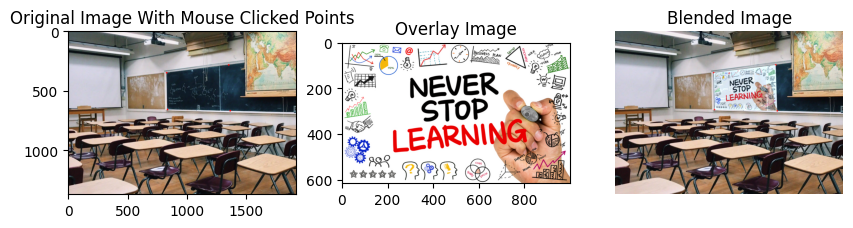

In [ ]:
MAX_POINTS = 4  # Maximum number of points to be clicked
clicked_points = np.zeros((MAX_POINTS, 2), dtype=np.float32)  # Array to store clicked points
point_count = 0

# Load the reference and overlay images
def load_images(reference_path, overlay_path):
    reference_image = cv.imread(reference_path, cv.IMREAD_COLOR)
    overlay_image = cv.imread(overlay_path, cv.IMREAD_COLOR)

    if reference_image is None or overlay_image is None:
        raise ValueError("Error loading images. Check file paths.")

    return reference_image, overlay_image

# Mouse callback function to record points clicked on the reference image
def record_mouse_clicks(event, x, y, flags, param):
    global point_count, clicked_points
    if event == cv.EVENT_LBUTTONDOWN and point_count < MAX_POINTS:
        # Draw red circle on click (optional, can be removed if not needed)
        cv.circle(reference_image, (x, y), 7, (0, 0, 255), -1)  # Draw red circle on click
        clicked_points[point_count] = [x, y]
        point_count += 1
        print(f"Point {point_count} recorded at ({x}, {y})")

# Display the reference image and capture mouse clicks
def display_image_and_capture_points(image):
    global point_count
    cv.namedWindow('Reference Image')
    cv.setMouseCallback('Reference Image', record_mouse_clicks)

    while True:
        cv.imshow('Reference Image', image)
        if point_count == MAX_POINTS:  # Exit loop when maximum points are clicked
            break
        if cv.waitKey(20) & 0xFF == 27:  # Press 'Esc' to exit
            print("Process terminated by user.")
            cv.destroyAllWindows()
            exit()

    cv.destroyAllWindows()  # Close window after selecting points

# Warp the overlay image based on selected points
def warp_overlay_image(overlay_image, target_points):
    overlay_corners = np.array([[0, 0], [overlay_image.shape[1], 0],
                                 [overlay_image.shape[1], overlay_image.shape[0]],
                                 [0, overlay_image.shape[0]]], dtype=np.float32)

    homography_matrix, _ = cv.findHomography(overlay_corners, target_points)
    warped_overlay = cv.warpPerspective(overlay_image, homography_matrix,
                                         (reference_image.shape[1], reference_image.shape[0]))
    return warped_overlay

# Blend the reference image with the warped overlay image
def blend_images(base_image, overlay_image, alpha=0.8):
    return cv.addWeighted(base_image, 1, overlay_image, alpha, 0)

reference_image, overlay_image = load_images('classroom.png', 'text1.jpg')
display_image_and_capture_points(reference_image)

# Warp the overlay image using the selected points
warped_overlay = warp_overlay_image(overlay_image, clicked_points)

blended_image = blend_images(reference_image, warped_overlay)

plt.figure(figsize=(10, 5))

# Original Image with clicked points (if circles were drawn)
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(reference_image, cv.COLOR_BGR2RGB))
plt.title('Original Image With Mouse Clicked Points')

plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(overlay_image , cv.COLOR_BGR2RGB))
plt.title('Overlay Image')

# Blended Image (Overlay on Reference)
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()


In [3]:
# Import images
img_g1 = cv.imread('graf/img1.ppm')
img_g2 = cv.imread('graf/img2.ppm')
img_g3 = cv.imread('graf/img3.ppm')
img_g4 = cv.imread('graf/img4.ppm')
img_g5 = cv.imread('graf/img5.ppm')

assert img_g1 is not None
assert img_g2  is not None
assert img_g3 is not None
assert img_g4 is not None
assert img_g5 is not None

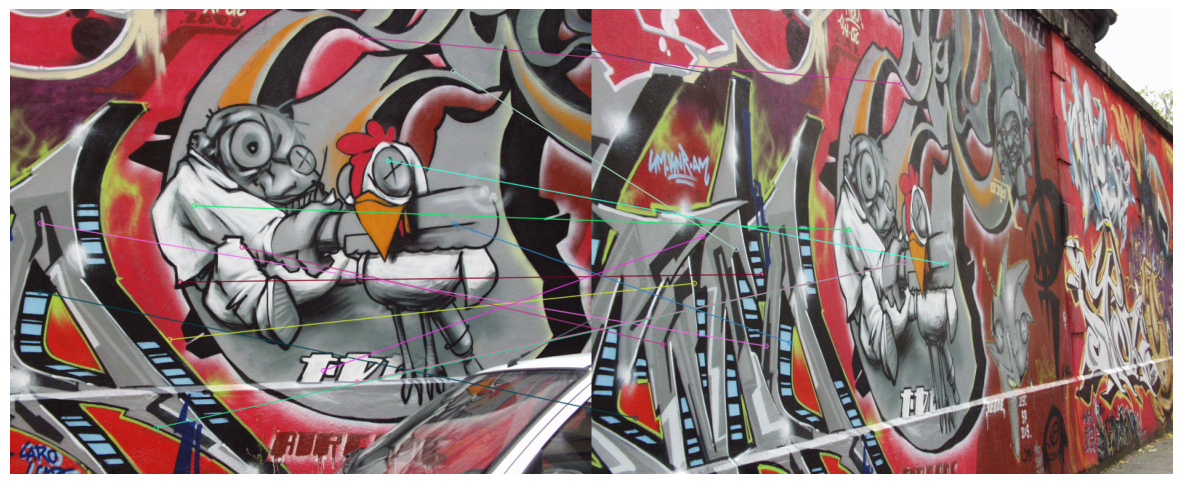

In [10]:


def sift_feature_matching(image1, image2):
    GOOD_MATCH_PERCENT = 0.65

    # Detect SIFT features
    sift_detector = cv.SIFT_create()
    keypoints1, descriptors1 = sift_detector.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift_detector.detectAndCompute(image2, None)

    # Match features using BFMatcher
    matcher = cv.BFMatcher()
    raw_matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Filter good matches using Lowe's ratio test
    good_matches = []
    for match1, match2 in raw_matches:
        if match1.distance < GOOD_MATCH_PERCENT * match2.distance:
            good_matches.append(match1)

    # Extract location of good matches
    points_image1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points_image2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points_image1[i, :] = keypoints1[match.queryIdx].pt
        points_image2[i, :] = keypoints2[match.trainIdx].pt

    # Visualize the matches
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.axis('off')
    matched_visual = cv.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=2)
    plt.imshow(cv.cvtColor(matched_visual, cv.COLOR_BGR2RGB))
    plt.show()

    return np.concatenate((points_image1, points_image2), axis=1)


correspondences_1_5 = sift_feature_matching(img_g1, img_g5)


In [5]:
def compute_homography(point_pairs):
    equations = []
    for pair in point_pairs:
        p1 = np.matrix([pair[0], pair[1], 1])  # (x1, y1)
        p2 = np.matrix([pair[2], pair[3], 1])  # (x2, y2)

        # Create equations for homography computation
        eq1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2),
               0, 0, 0, p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0)]
        eq2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2),
               p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1)]

        equations.extend([eq1, eq2])

    # Perform SVD to solve the equations
    equations_matrix = np.matrix(equations)
    _, _, v = np.linalg.svd(equations_matrix)

    # Reshape the solution to a 3x3 matrix and normalize
    homography = np.reshape(v[8], (3, 3))
    homography = (1 / homography.item(8)) * homography
    return homography

import random

def compute_loss(match_pair, homography_matrix):
    point1 = np.transpose(np.matrix([match_pair[0], match_pair[1], 1]))
    point2 = np.transpose(np.matrix([match_pair[2], match_pair[3], 1]))

    # Transform point1 using the homography
    transformed_point = np.dot(homography_matrix, point1)
    transformed_point /= transformed_point.item(2)

    # Calculate the error
    error = np.linalg.norm(point2 - transformed_point)
    return error

def select_random_samples(points_list, sample_size=3):
    random.seed(0)
    selected_indices = random.sample(range(len(points_list)), sample_size)
    return np.array([points_list[i] for i in selected_indices])

def ransac_algorithm(matched_points):
    max_inliers = 0
    best_homography = None

    for _ in range(10):
        sampled_points = select_random_samples(matched_points)

        # Compute homography from sampled points
        homography = compute_homography(sampled_points)
        inlier_count = 0

        # Count inliers
        for match in matched_points:
            if compute_loss(match, homography) < 3:
                inlier_count += 1

        # Update the best homography if more inliers are found
        if inlier_count > max_inliers:
            max_inliers = inlier_count
            best_homography = homography

    return best_homography


homography_1_5 = ransac_algorithm(correspondences_1_5)

print(homography_1_5)

[[ 0.78176252 -0.75556942  0.09696644]
 [ 1.30358382 -1.24252927 -0.43687914]
 [ 0.00253628 -0.00546429  1.        ]]


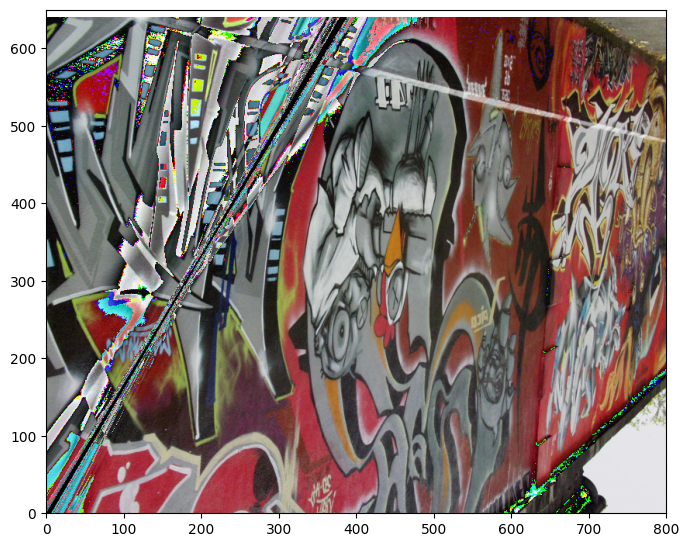

In [15]:


warped_image = cv.warpPerspective(img_g1, homography_1_5, (img_g5.shape[1], img_g5.shape[0]))
# warped_image[0:img_g5.shape[0], 0:img_g5.shape[1]] = img_g5

mask = (warped_image== 0) # Create a mask of the stitched image
warped_image += img_g5 # Add the first image to the stitched image
warped_image[mask] = 0 # Set the pixels of the stitched image that are not part of the second image to 0


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([0, 800])
ax.set_ylim([0, 650])
ax.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
plt.show()


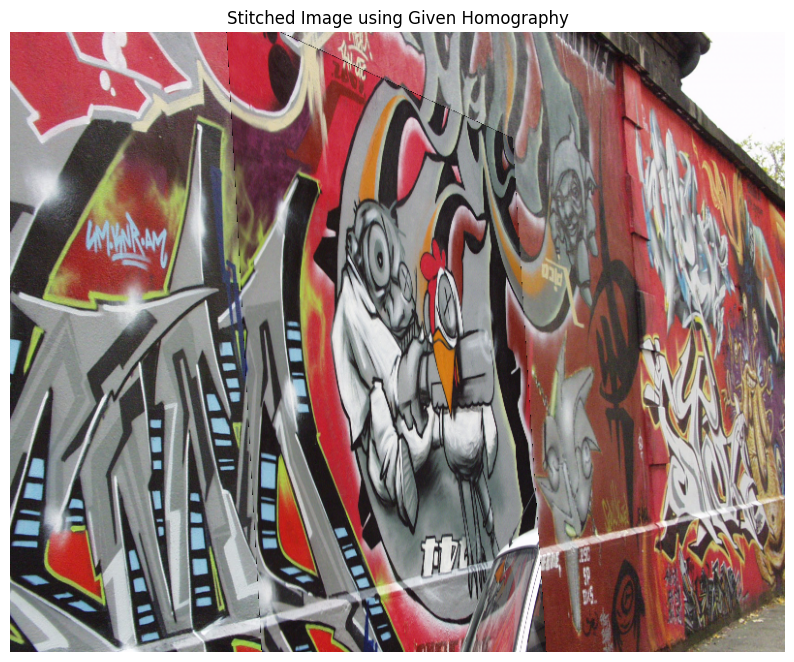

In [17]:
# Load the given homography matrix
H1to5P = np.loadtxt('graf/H1to5P')

# Warp img1 onto img5 using the given homography
img1_warped = cv.warpPerspective(img_g1, H1to5P, (img_g5.shape[1], img_g5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv.threshold(cv.cvtColor(img1_warped, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv.bitwise_not(img1_mask)

# Blend the two images together
result = cv.bitwise_and(img_g5, img_g5, mask=img5_mask)
result = cv.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image using Given Homography')
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
print(H1to5P)

[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


In [ ]:
# Calculate the absolute difference between the calculated and given homography matrices
homography_difference = np.abs(final_homography - H1to5P)

# Print the difference
print("Difference between calculated and given homography matrices:\n", homography_difference)

Difference between calculated and given homography matrices:
 [[7.96440714e+00 6.89555305e+00 7.44279435e+01]
 [6.70867327e+00 7.07268706e+00 2.90733368e+02]
 [1.93250565e-02 1.67789371e-02 0.00000000e+00]]


In [ ]:
plt.figure(figsize      =(10, 10))                  

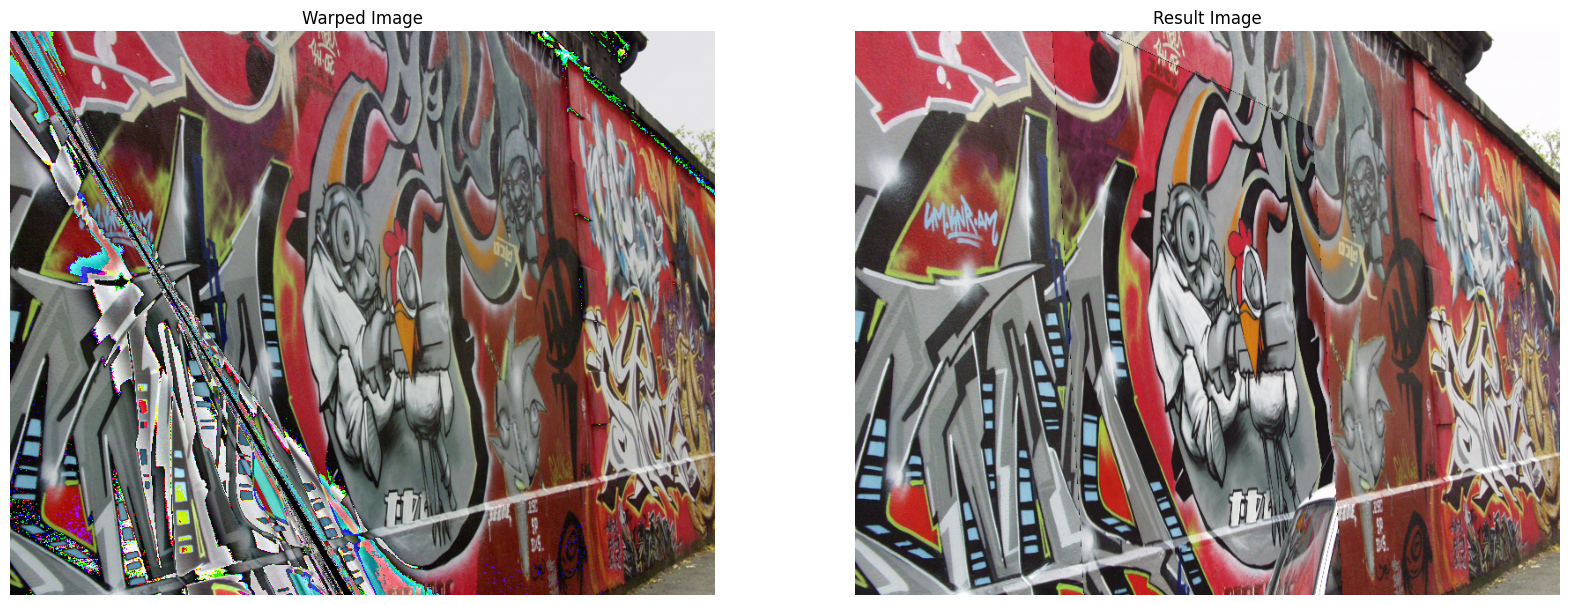

In [19]:
plt.figure(figsize=(20, 10))

# Plot warped image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

# Plot result image
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('Result Image')
plt.axis('off')

plt.show()